## MINERvA's Boosted Decision Tree Neutrino MC Events Reweight with GENIE and NUISANCE Flat Tree
This note book demonstrates a reweight analysis using MINERvA's GENIE medium energy numu-carbon MC events. 

In [1]:
import sys
# Change this path to your working directory where BDTReweight is installed:
sys.path.append('/exp/minerva/app/users/zihaolin/REWEIGHTworkdir/')

from BDTReweight.analysis import transform_momentum_to_reaction_frame, create_dataframe_from_nuisance, draw_source_target_distributions_and_ratio
from BDTReweight.nuisance_flat_tree import NuisanceFlatTree
from BDTReweight.reweighter import Reweighter
import numpy as np


### MINERvA's ME numu-carbon CCQE-like 1mu1p0n reweight demo
- Source generator: GENIE v2.12.6
- Target generator: GENIE v3.04.00 tune AR23_20i_00_000

This notebook uses GENIE MC sample NUISANCE flat tree root files stored on MINERvA GPVM.

Prepare trees from MC samples for training:

In [2]:
# prepare source sample NuisanceFlatTree for training
tree_source_train = NuisanceFlatTree(
    # A GENIE v2.12.6 sample:
    '/pnfs/minerva/persistent/Models/GENIE/Medium_Energy/FHC/v2_12_6/tracker/minervabase/Flattened_GENIE_v2_12_6_DefaultMEC_numu_CH_105_ghep.root'
)
mask_CCQELike = tree_source_train.get_mask_CCQELike()
tree_source_train.update_tree_with_mask(mask_CCQELike)

# prepare target sample NuisanceFlatTree for training
tree_target_train = NuisanceFlatTree(
    # A GENEIE v3.04.00 AR23 sample I generated:
    '/exp/minerva/data/users/zihaolin/MC_outputs/GENIE/GENIEv3_AR23_MINERvA_ME_FHC_numu_C12_NUISFLAT.root',
    # Alternatively, try GENIE v3 G18_10a:
    # '/pnfs/minerva/persistent/Models/GENIE/Medium_Energy/FHC/v3_0_6/tracker/G18_10a_02_11a/CH/flat_GENIE_G18_10a_02_11a_50M.root',
    # Use akward array's kwargs to control sample size
    entry_start=0, entry_stop=1000000
)
mask_CCQELike = tree_target_train.get_mask_CCQELike()
tree_target_train.update_tree_with_mask(mask_CCQELike)


In [3]:
# Specify detecting thresholds and topology particle counts:
KE_thresholds={'proton':0.05, 'neutron':0.01}
particle_counts = {'muon':'==1', 'proton':'==1', 'neutron':'==0'}
# List variables to extract from tree: 
variable_exprs = [
    'dalphat', 'dpt', 'dphit', 'Enu_true',
    'leading_muon_px', 'leading_muon_py', 'leading_muon_pz', 'leading_muon_KE',
    'leading_proton_px', 'leading_proton_py', 'leading_proton_pz', 'leading_proton_KE',
    'total_proton_px', 'total_proton_py', 'total_proton_pz', 'total_proton_KE',
]

# create a mask for CCQE-like 1mu1p0n topology and Create dataframes
mask_1mu1p0n = tree_source_train.get_mask_topology(particle_counts = particle_counts, KE_thresholds = KE_thresholds)
source_train_1p0n = create_dataframe_from_nuisance(tree_source_train, variable_exprs=variable_exprs, mask=mask_1mu1p0n)

mask_1mu1p0n = tree_target_train.get_mask_topology(particle_counts = particle_counts, KE_thresholds = KE_thresholds)
target_train_1p0n = create_dataframe_from_nuisance(tree_target_train, variable_exprs=variable_exprs, mask=mask_1mu1p0n)

# convert to reaction frame:
particle_names = ['leading_proton', 'total_proton']
source_train_1p0n = transform_momentum_to_reaction_frame(source_train_1p0n, selector_lepton='leading_muon', particle_names=['leading_proton', 'total_proton'])
target_train_1p0n = transform_momentum_to_reaction_frame(target_train_1p0n, selector_lepton='leading_muon', particle_names=['leading_proton', 'total_proton'])


### Train reweighter
Now we have all the ingredients, time to reweight!

In [4]:
# Specify reweight training variables:
reweight_variables=['leading_proton_px','leading_proton_py','leading_proton_pz','total_proton_KE','leading_muon_py','leading_muon_pz']

# Create Reweighter (inherited from hep_ml.reweight.GBReweighter) instance: 
reweighter = Reweighter(n_estimators=30, learning_rate=0.1, max_depth=30, min_samples_leaf=30, gb_args={'subsample': 1.0})

# Traing reweighter using source and target sample's reweight variables:
reweighter.fit(source_train_1p0n[reweight_variables], target_train_1p0n[reweight_variables])


,n_estimators,30
,learning_rate,0.1
,max_depth,30
,min_samples_leaf,30
,loss_regularization,5
,gb_args,{'subsample': 1.0}


In [5]:
# Set target weights to 1.0 for all events:
target_train_1p0n['weight'] = 1.0

# Predict weights for source model:
source_train_1p0n['weight'] = reweighter.predict_matched_total_weights(
    source_train_1p0n[reweight_variables], 
    original_weight=None,
    target_weight=target_train_1p0n['weight']
)

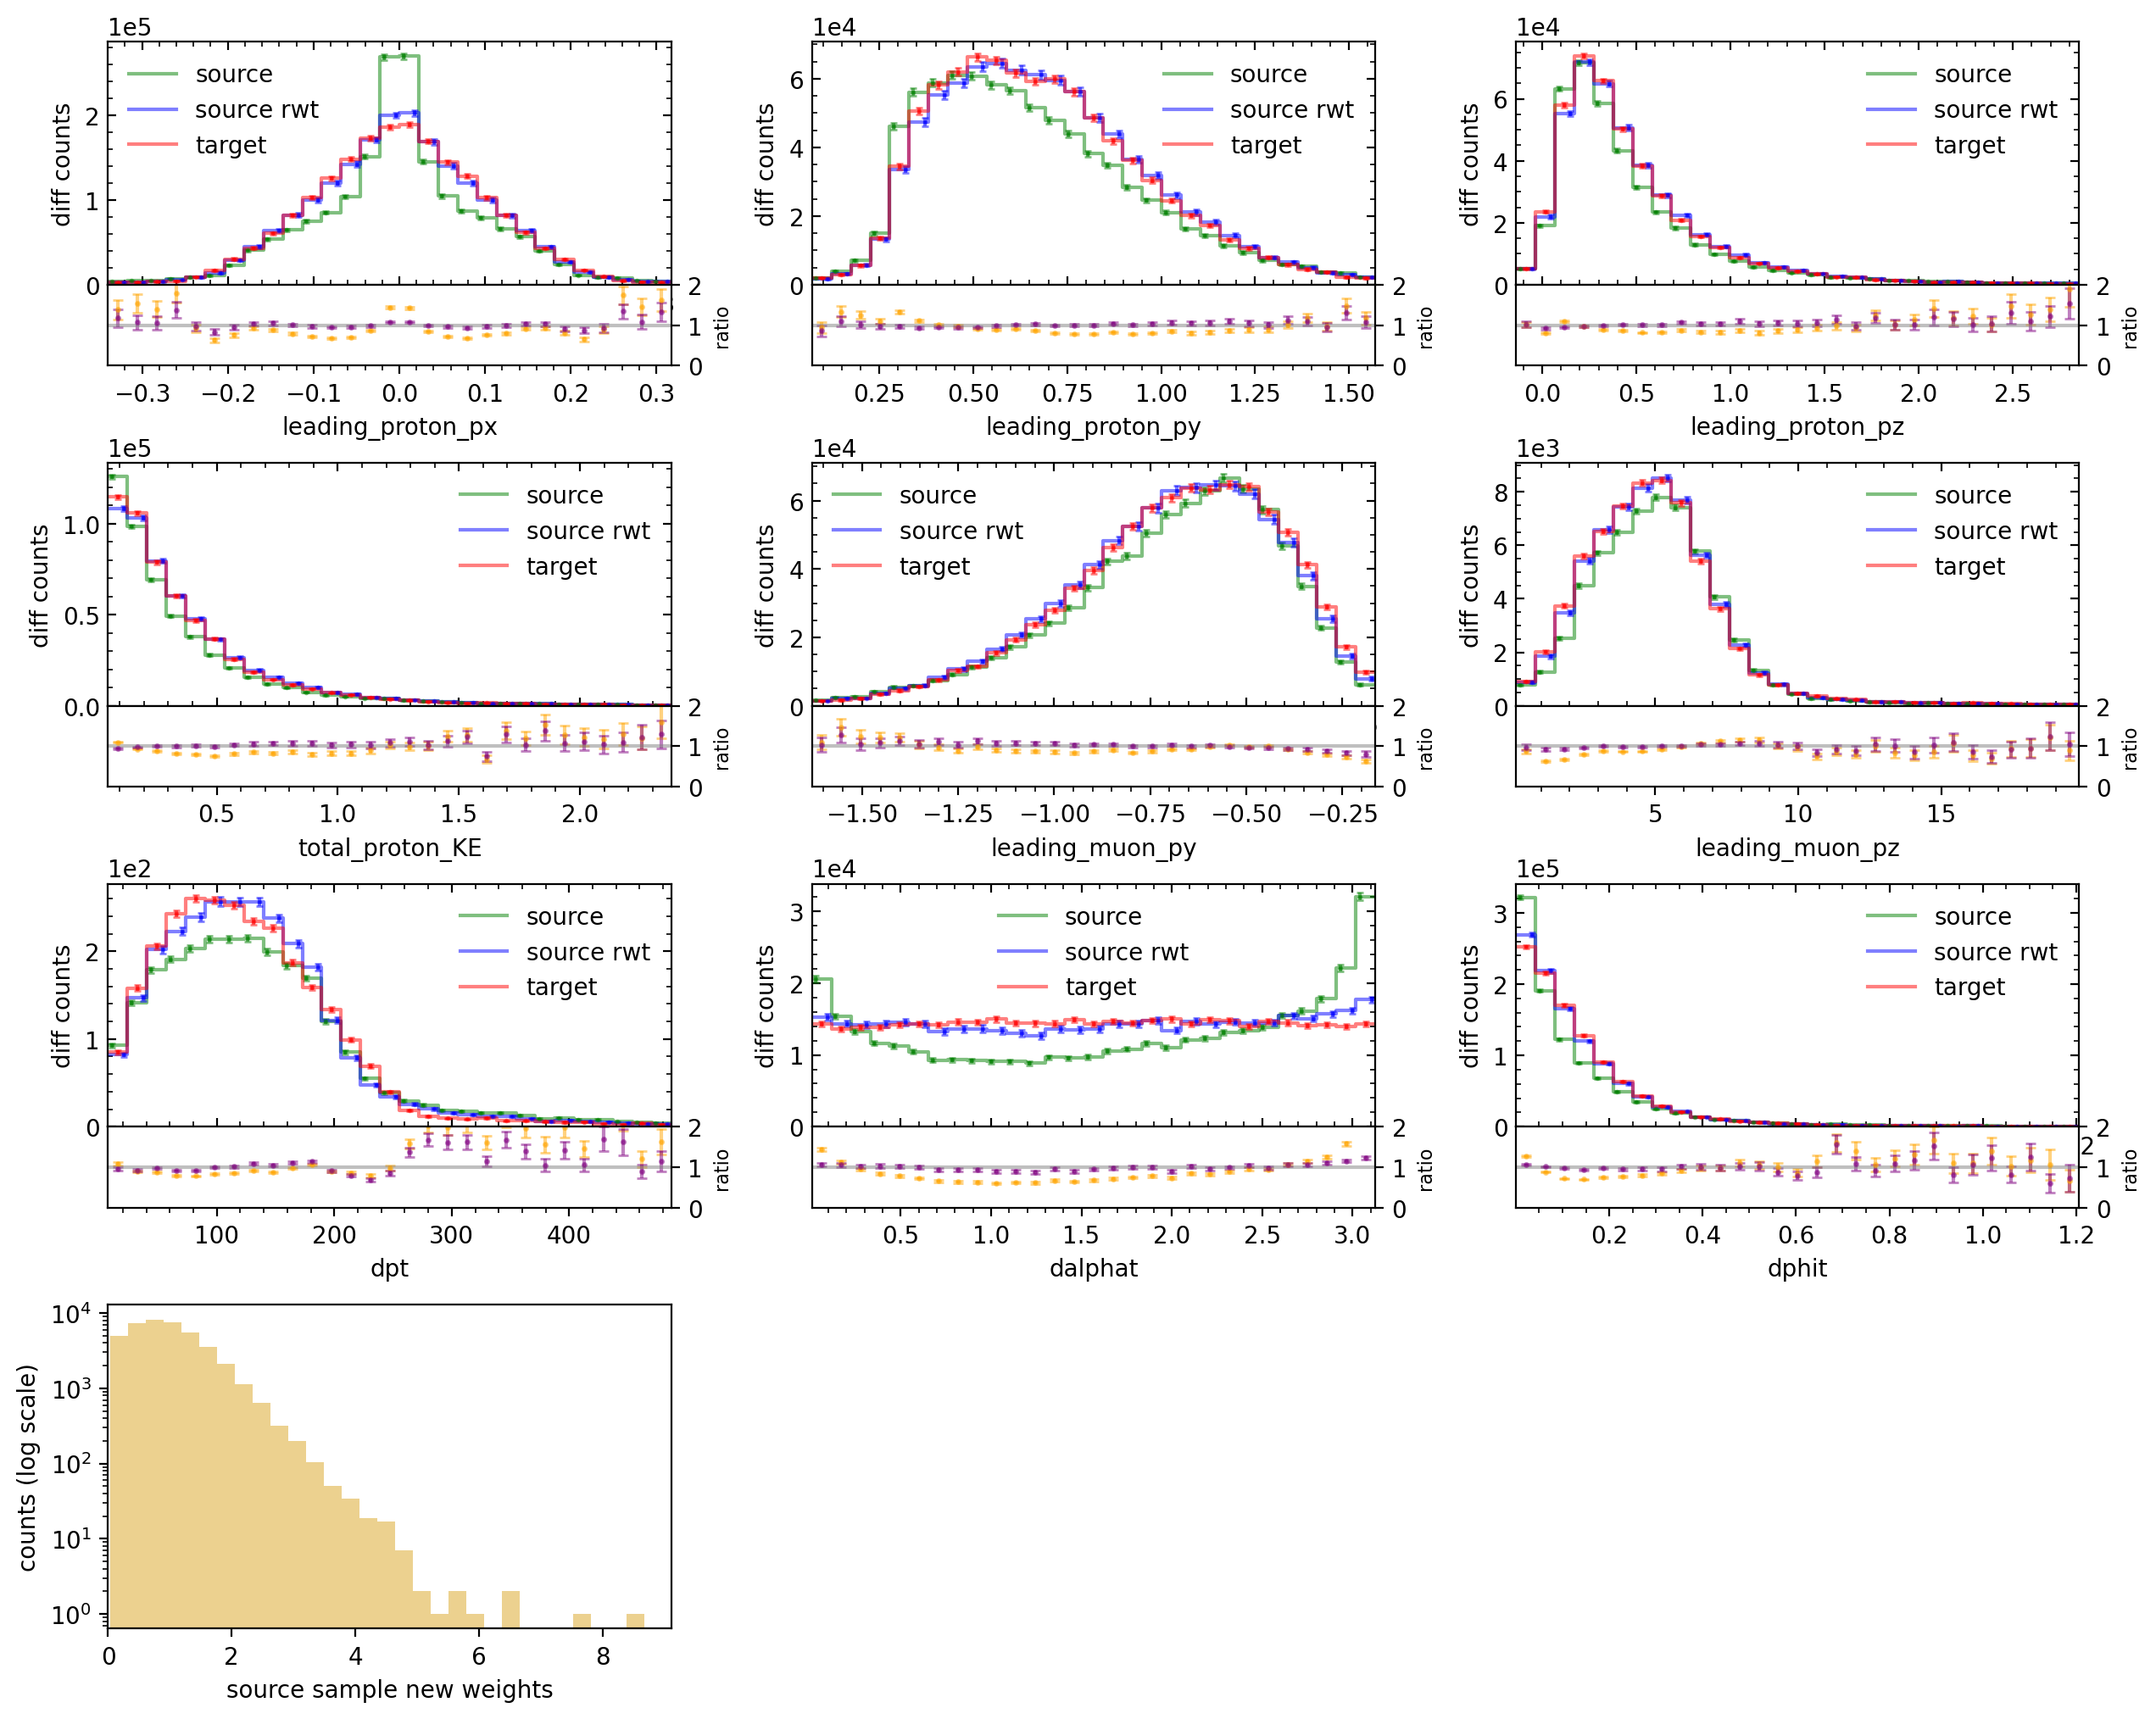

In [6]:
# Specify variables to be plotted as histograms:
drawing_variables = ['leading_proton_px','leading_proton_py','leading_proton_pz','total_proton_KE','leading_muon_py','leading_muon_pz','dpt','dalphat','dphit', 'weight']

# Draw distributions:
draw_source_target_distributions_and_ratio(source_train_1p0n, target_train_1p0n, 
    variables = drawing_variables,
    source_weights = np.ones(len(source_train_1p0n)),
    target_weights = np.ones(len(target_train_1p0n)), 
    new_source_weights = source_train_1p0n['weight']
)

### Save or load Reweighter via Python pickle

In [7]:
# reweighter.save_to_pickle('path/to/your/reweighter/folder/reweighter.pkl')

# reweighter.save_to_pickle('/exp/minerva/data/users/zihaolin/BDTReweighters/saved_reweighters_pickle/reweighter_MINERvA_ME_numuCarbon_CCQELike_GENIEv2_to_v3AR23_1mu1p0n.pkl')

reweighter = Reweighter.load_from_pickle(
    '/exp/minerva/data/users/zihaolin/BDTReweighters/saved_reweighters_pickle/reweighter_MINERvA_ME_numuCarbon_CCQELike_GENIEv2_to_v3AR23_1mu1p0n.pkl'
)
